In [1]:
from unityagents import UnityEnvironment
# from mlagents_envs.environment import UnityEnvironment
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
f = 'Reacher_Windows'
# f = 'Reacher_Windows_20'
# f = 'Reacher_Linux'
# f = 'Reacher_Linux_NoVis'
# f = 'Reacher_Linux_20'
# f = 'Reacher_Linux_NoVis_20'
no_graphics = False
env = UnityEnvironment(file_name='{}/Reacher'.format(f), seed=1,no_graphics=no_graphics, worker_id=8)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33


## Runners

In [5]:
import tools as ts
from deep_rl import *


first = [
    # {'target_network_mix':0.001,'discount':0.7,'gradient_clip':10},
    {
     # 'fc1':400,'fc2':300,
     # 'weight_decay':0.012,'weight_decay_act':0.0,
     'actor_lr':1e-4,'critic_lr':1e-4,
     # 'target_network_mix':0.000327,'discount':0.715992,'gradient_clip':3,
     # 'td3_noise':0.2,'td3_noise_clip':0.5,'td3_delay':2,
    }
]

space_cfg = [
#        {'name' : 'fc1',             'type' : 'int', 'lb' : 300, 'ub' : 500, "step": 100},
#        {'name' : 'fc2',             'type' : 'int', 'lb' : 200, 'ub' : 400, "step": 100},
        #{'name' : 'fc3',             'type' : 'int', 'lb' : 100, 'ub' : 400, "step": 100},
    
        # {'name' : 'gradient_clip',       'type' : 'int', 'lb' : 1.0, 'ub' : 16.0},
        # {'name' : 'discount',            'type' : 'num', 'lb' : 0.5, 'ub' : 1.0},
        # {'name' : 'target_network_mix',  'type' : 'pow', 'lb' : 1e-6, 'ub' : 1e-2},
    
       {'name' : 'actor_lr',        'type' : 'pow', 'lb' : 1e-7, 'ub' : 1e-2},
       {'name' : 'critic_lr',       'type' : 'pow', 'lb' : 1e-7, 'ub' : 1e-2},
       # {'name' : 'weight_decay_act','type' : 'num', 'lb' : 0.0, 'ub' : 0.02},
       # {'name' : 'weight_decay',    'type' : 'num', 'lb' : 0.0, 'ub' : 0.02},
    
       # {'name' : 'td3_noise',        'type' : 'num', 'lb' : 0.1, 'ub' : 0.4},
       # {'name' : 'td3_noise_clip',   'type' : 'num', 'lb' : 0.4, 'ub' : 0.7},
       # {'name' : 'td3_delay',        'type' : 'int', 'lb' : 1, 'ub' : 5},
        ]

In [6]:
config = ts.initConf_td3(state_size,action_size,brain_name,env)
config.update_fields = [
    #'fc1','fc2',
    # 'weight_decay','weight_decay_act',
    'actor_lr','critic_lr',
    # 'discount','target_network_mix','gradient_clip',
    # 'td3_noise','td3_noise_clip','td3_delay',
]
# N:0.360176	N_Clip:0.667340	Delay:3
# N:0.341247	N_Clip:0.609734	Delay:3
config.fc1 = 400
config.fc2 = 300
# config.fc3 = 193
config.weight_decay_act = 0.0
config.weight_decay = 0.012
config.actor_lr = 1e-4
config.critic_lr = 1e-4
config.target_network_mix = 0.000327
config.discount = 0.715992
config.gradient_clip = 3
config.td3_noise = 0.360176
config.td3_noise_clip = 0.609734
config.td3_delay = 3

# config.act_clip = 9

Config.DEVICE = torch.device('cpu')
config.device = Config.DEVICE
config.eval_episodes = 400
config.scores_window = 40
best,scores = ts.tune(config,space_cfg,max_iter = 16,first=first)
print('Best:{}'.format(best) , flush = True)

Start[0]	a_Lr:0.00010000	c_Lr:0.00010000	
Episode[0] 40	a_Lr:0.00010000	c_Lr:0.00010000	 a-Average Score: 0.59
Episode[0] 80	a_Lr:0.00010000	c_Lr:0.00010000	 a-Average Score: 0.81
Finished![0] 120	a_Lr:0.00010000	c_Lr:0.00010000	 a-Average Score: 0.75
Start[1]	a_Lr:0.00000010	c_Lr:0.00000010	
Episode[1] 40	a_Lr:0.00000010	c_Lr:0.00000010	 a-Average Score: 0.07
Episode[1] 80	a_Lr:0.00000010	c_Lr:0.00000010	 a-Average Score: 0.48
Finished![1] 120	a_Lr:0.00000010	c_Lr:0.00000010	 a-Average Score: 0.40
Start[2]	a_Lr:0.00003162	c_Lr:0.00003162	
Episode[2] 40	a_Lr:0.00003162	c_Lr:0.00003162	 a-Average Score: 0.50
Episode[2] 80	a_Lr:0.00003162	c_Lr:0.00003162	 a-Average Score: 0.53
Episode[2] 120	a_Lr:0.00003162	c_Lr:0.00003162	 a-Average Score: 0.55
Finished![2] 160	a_Lr:0.00003162	c_Lr:0.00003162	 a-Average Score: 0.55
Start[3]	a_Lr:0.00010756	c_Lr:0.00997006	
Episode[3] 40	a_Lr:0.00010756	c_Lr:0.00997006	 a-Average Score: 0.03
Episode[3] 80	a_Lr:0.00010756	c_Lr:0.00997006	 a-Average Score:

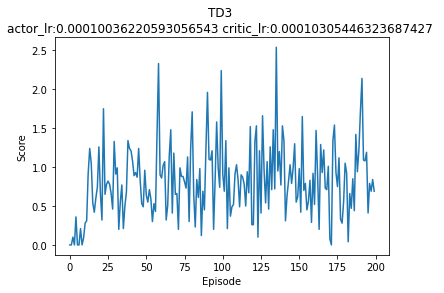

In [7]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode')
st = ''
for k in config.update_fields:
    st += '{}:{} '.format(k,best[k])
plt.title("TD3 \n{}".format(st))
plt.show()

In [8]:
env.close()